#### 諸々の動作確認用

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from keras.models import load_model
from keras.preprocessing.image import load_img
from tqdm import tqdm

sys.path.append('..')
from src import Utils

loadpkl = Utils.loadpkl
predict_result = Utils.predict_result
IMG_SIZE_TARGET = Utils.IMG_SIZE_TARGET
my_iou_metric = Utils.my_iou_metric

%matplotlib inline

In [ ]:
train_df = loadpkl('../output/train_df.pkl')
test_df = loadpkl('../output/test_df.pkl')

In [5]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.525490196078, 0.513725490196, 0.5254901960...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.341176470588, 0.376470588235, 0.3333333333...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.56862745098, 0.466666666667, 0.32549019607...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.541176470588, 0.474509803922, 0.3960784313...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.0666666666667, 0.078431372549, 0.090196078...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


In [6]:
test_df.head()

,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


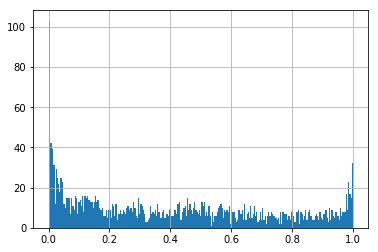

In [11]:
train_df.coverage[train_df.coverage>0.0].hist(bins=255)

In [25]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm(test_df.index)]).reshape(-1, IMG_SIZE_TARGET, IMG_SIZE_TARGET, 1)


100%|██████████| 18000/18000 [00:07<00:00, 2295.16it/s]

In [31]:
model = load_model('../output/unet_best0.model', custom_objects={'my_iou_metric': my_iou_metric})

ResourceExhaustedError: OOM when allocating tensor with shape[256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/Variable_103/Assign = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/Variable_103, training/Adam/zeros_100)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/Adam/Variable_103/Assign', defined at:
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-e375e04c1154>", line 1, in <module>
    model = load_model('../output/unet_best0.model', custom_objects={'my_iou_metric': my_iou_metric})
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/engine/saving.py", line 294, in load_model
    model._make_train_function()
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/engine/training.py", line 498, in _make_train_function
    loss=self.total_loss)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/optimizers.py", line 482, in get_updates
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/optimizers.py", line 482, in <listcomp>
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 702, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 400, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 412, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/state_ops.py", line 216, in assign
    validate_shape=validate_shape)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/Variable_103/Assign = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/Variable_103, training/Adam/zeros_100)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

